In [1]:
import numpy as np
import glob

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

import matplotlib.pyplot as plt

import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [3]:
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [4]:
seed = 111
batch_size = 8
img_size = (224, 224)

datagen_args = dict(
    rotation_range=5,
    shear_range=10,
    zoom_range=[1, 1.2],
    vertical_flip=True,
    horizontal_flip=True
)

image_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input, 
    validation_split=0.2,
    **datagen_args,
)

mask_datagen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    **datagen_args
)

image_generator = image_datagen.flow_from_directory(
    './PaintDetectionDataset/train/images/', 
    class_mode=None, 
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='training'
)

mask_generator = mask_datagen.flow_from_directory(
    './PaintDetectionDataset/train/masks/',
    class_mode=None, 
    color_mode='grayscale',
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='training'
)

train_generator = zip(image_generator, mask_generator)

Found 186 images belonging to 1 classes.
Found 186 images belonging to 1 classes.


In [5]:
image_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input, 
    validation_split=0.2
)
mask_datagen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

val_image_generator = image_datagen.flow_from_directory(
    './PaintDetectionDataset/train/images/', 
    class_mode=None, 
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation'
)
val_mask_generator = mask_datagen.flow_from_directory(
    './PaintDetectionDataset/train/masks/',
    class_mode=None, 
    color_mode='grayscale',
    seed=seed,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation'
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 46 images belonging to 1 classes.
Found 46 images belonging to 1 classes.


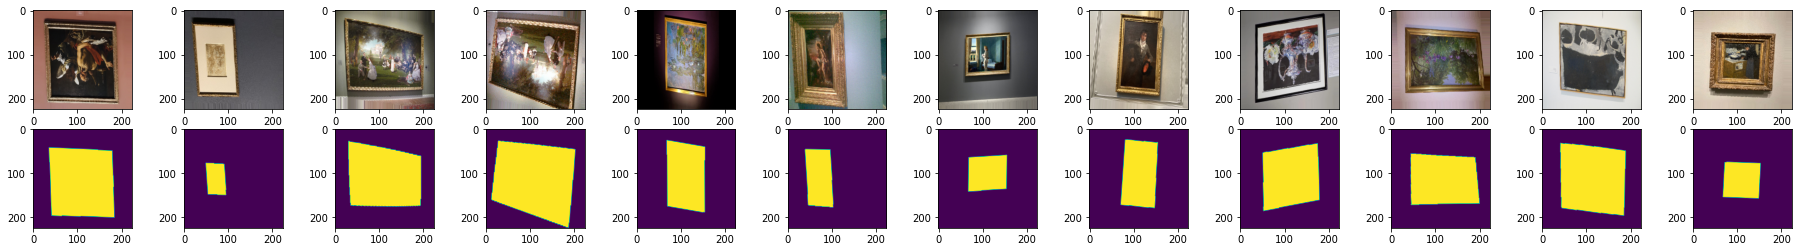

In [7]:
fig, axs = plt.subplots(2, 12, figsize=(32, 4))
for i in range(12):
    x = next(train_generator)
    axs[0, i].imshow(x[0][0])
    axs[1, i].imshow(x[1][0])

In [8]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
model.summary()

2022-02-05 17:40:10.425492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 17:40:10.448078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 17:40:10.448232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 17:40:10.448528: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [9]:
import math
def spe(y, batch_size):
    return int(math.ceil((1. * y) / batch_size))

In [10]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-5), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

callbacks = [
    keras.callbacks.ModelCheckpoint("painting_segmentation.h5", save_best_only=True)
]

epochs = 200

history = model.fit(
    train_generator, 
    epochs=epochs, 
    steps_per_epoch=spe(186, batch_size), 
    validation_data=val_generator,
    validation_steps=spe(46, batch_size),
    callbacks=callbacks
)

Epoch 1/100


2022-02-05 17:40:18.922960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


24/24 [==============================] - 11s 311ms/step - loss: 1.4584 - iou_score: 0.2050 - val_loss: 1.4763 - val_iou_score: 0.2410
Epoch 2/100
24/24 [==============================] - 6s 275ms/step - loss: 1.3031 - iou_score: 0.2550 - val_loss: 1.4619 - val_iou_score: 0.2600
Epoch 3/100
24/24 [==============================] - 6s 279ms/step - loss: 1.2262 - iou_score: 0.2850 - val_loss: 1.4110 - val_iou_score: 0.2683
Epoch 4/100
24/24 [==============================] - 7s 282ms/step - loss: 1.1878 - iou_score: 0.3018 - val_loss: 1.3838 - val_iou_score: 0.2388
Epoch 5/100
24/24 [==============================] - 6s 270ms/step - loss: 1.1346 - iou_score: 0.3256 - val_loss: 1.3590 - val_iou_score: 0.2286
Epoch 6/100
24/24 [==============================] - 6s 261ms/step - loss: 1.0962 - iou_score: 0.3395 - val_loss: 1.3676 - val_iou_score: 0.2071
Epoch 7/100
24/24 [==============================] - 6s 279ms/step - loss: 1.0550 - iou_score: 0.3636 - val_loss: 1.4173 - val_iou_score: 0.1

In [11]:
def plot_history(history, save=False, filepath=None):
    x_plot = list(range(1, len(history["loss"]) + 1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.plot(x_plot, history["loss"])
    ax1.plot(x_plot, history["val_loss"])
    ax1.legend(["Training", "Validation"])

    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("IOU")
    ax2.plot(x_plot, history["iou_score"])
    ax2.plot(x_plot, history["val_iou_score"])
    ax2.legend(["Training", "Validation"], loc="lower right")

    fig.show()

    if save and filepath is not None:
        fig.savefig(filepath)

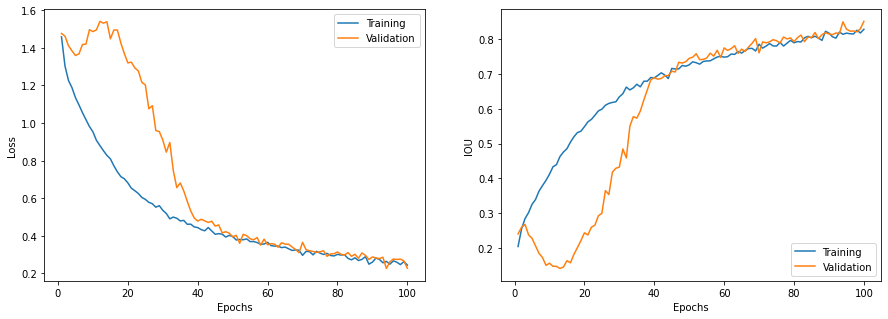

In [12]:
plot_history(history.history)

IndexError: index 3 is out of bounds for axis 0 with size 3

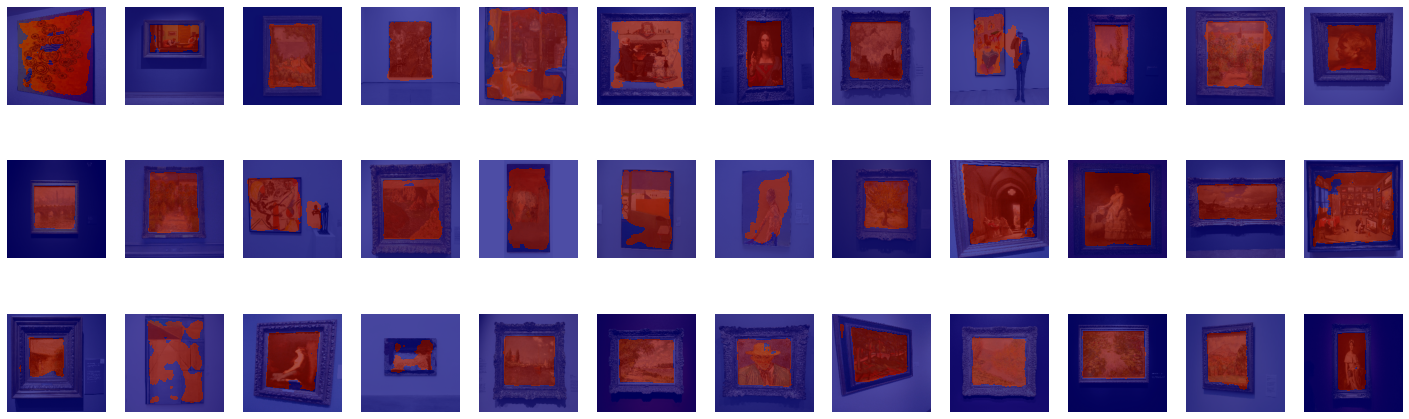

In [16]:
testdir = './PaintDetectionDataset/test/images/img/*.jpg'

fig, axes = plt.subplots(3, 12, sharex=True, sharey=True, figsize=(25, 8))

paths = glob.glob(testdir)

images = np.zeros((len(paths), 224, 224, 3))
for i, img_path in enumerate(paths):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    img = preprocess_input(img)
    images[i] = img

preds = model.predict(images)

for i in range(len(paths)):
    mask = preds[i]
    mask = (mask >= 0.5).astype(np.uint8)

    k = i // 12
    j = i % 12

    axes[k, j].imshow(images[i])
    axes[k, j].imshow(mask, 'jet', interpolation='none', alpha=0.7)
    axes[k, j].axis('off')

fig.tight_layout()